<a href="https://colab.research.google.com/github/Dona134/Metaphor-Classification-NLP/blob/main/main_code_upd_(further_work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Dona134/Metaphor-Classification-NLP/blob/main/main_code_upd%20(further%20work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab + Imports + Paths

In [1]:
import pandas as pd, numpy as np, ast, json
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import torch, torch.nn as nn
from transformers import (
    XLMRobertaTokenizerFast, XLMRobertaForTokenClassification,
    Trainer, TrainingArguments
)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings; warnings.filterwarnings('ignore')
from transformers import logging; logging.set_verbosity_error()
import matplotlib.pyplot as plt; import seaborn as sns
from google.colab import drive; drive.mount('/content/drive')
import os; os.environ['TOKENIZER_PARALLELISM'] = 'false'

PROJECT_ROOT = '/content/drive/MyDrive/Metaphor-Classification-NLP'
DATA_PROC = f'{PROJECT_ROOT}/data/processed'

Mounted at /content/drive


## Config

In [69]:
EXPERIMENT = "EN"  # "EN", "RU_ZERO", "RU_HEAD", "RU_FULL", "EN_BALANCED_POS"
MAX_LEN = 32
BATCH_SIZE = 16
SEED = 42
# Final weights from your runs
EN_CLASS_WEIGHTS = torch.tensor([0.232, 1.384])
#EN_CLASS_WEIGHTS = torch.tensor([0.58, 3.54])
RU_CLASS_WEIGHTS = torch.tensor([0.53, 8.89])  # 95/5 RU imbalance

tokenizer = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base', add_prefix_space=True)

## Utilities: Dataset + Trainer

In [3]:
from torch.utils.data import Dataset

class MetaphorSentenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Encodings for Trainer
        self.encodings = {
            'input_ids': [],
            'attention_mask': [],
            'labels': []
        }

        # Separate lists to use later for evaluation
        self.word_ids_list = []
        self.simple_pos_list = []

        # POS mapping (simplified)
        self.simple_pos_mapping = {'nan': 'na', 'verb': 'verb', 'noun': 'noun', 'adv': 'adv',
                                   'adj': 'adj', 'SPECIAL': 'SPECIAL',
                                   'SUBWORD': 'SUBWORD', 'UNKNOWN_POS': 'UNKNOWN_POS', 'PAD': 'PAD'}

        for idx, row in self.df.iterrows():
            words = [str(w) for w in row["words"]]
            labels = [int(l) for l in row["labels"]]
            simple_pos = [str(p) for p in row["pos"]] # These are the actual POS tags

            encoding = self.tokenizer(
                words,
                is_split_into_words=True,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )

            word_ids = encoding.word_ids(batch_index=0)
            aligned_labels = []
            aligned_pos = []

            prev_word_id = None
            for i, word_id in enumerate(word_ids):
                if word_id is None:
                    aligned_labels.append(-100)
                    aligned_pos.append("SPECIAL")
                elif word_id != prev_word_id:
                    aligned_labels.append(labels[word_id])
                    aligned_pos.append(simple_pos[word_id])
                    prev_word_id = word_id
                else:
                    aligned_labels.append(-100)
                    aligned_pos.append("SUBWORD")

            # Convert to tensors
            self.encodings['input_ids'].append(encoding['input_ids'].squeeze(0))
            self.encodings['attention_mask'].append(encoding['attention_mask'].squeeze(0))
            self.encodings['labels'].append(torch.tensor(aligned_labels, dtype=torch.long))

            # Save for evaluation
            self.word_ids_list.append(word_ids)
            self.simple_pos_list.append(aligned_pos)

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        # Support both single index and batch (list/ndarray) index
        if isinstance(idx, (int, np.integer)):
            return {key: self.encodings[key][idx] for key in self.encodings}
        # If idx is a list, tuple, or np.ndarray, return a batch
        if isinstance(idx, (list, tuple, np.ndarray)):
            return {key: [self.encodings[key][i] for i in idx] for key in self.encodings}
        raise TypeError(f"Invalid index type: {type(idx)}")

In [4]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.FloatTensor(class_weights)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        #Enhanced compute_loss with weighted cross entropy for class imbalance
        expected_keys = ["input_ids", "attention_mask", "labels"]
        model_inputs = {key: inputs[key] for key in expected_keys if key in inputs}

        labels = model_inputs.get("labels") # Get labels separately as they are used in loss calculation

        # Pass expected inputs to the model
        outputs = model(**model_inputs)
        logits = outputs.get("logits")

        # Move class weights to correct device
        device = logits.device
        class_weights_device = self.class_weights.to(device)

        # Create weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_device, ignore_index=-100)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [5]:
# Enhanced compute metrics with detailed class-specific metrics
def compute_metrics_enhanced(eval_pred):
    predictions, labels = eval_pred
    # Access the logits from the predictions tuple (predictions[0])
    predictions = predictions[0].argmax(axis=-1)

    # Remove ignored index (-100 values)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    # Calculate metrics for both classes
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': weighted_f1,
        'precision': weighted_precision,
        'recall': weighted_recall,
        'literal_f1': f1[0] if len(f1) > 0 else 0.0,
        'metaphor_f1': f1[1] if len(f1) > 1 else 0.0,
        'literal_precision': precision[0] if len(precision) > 0 else 0.0,
        'metaphor_precision': precision[1] if len(precision) > 1 else 0.0,
        'literal_recall': recall[0] if len(recall) > 0 else 0.0,
        'metaphor_recall': recall[1] if len(recall) > 1 else 0.0,
    }

## 3. POS Balancing (resampling)


In [6]:
def sample_balanced_pos(df, pos_categories_to_balance, random_state=42):
    """
    Samples sentences to achieve a roughly equal number of metaphorical tokens
    for the specified POS categories, based on the count of the most underrepresented category.
    """
    # First, count the occurrences of metaphorical tokens for each specified POS category
    pos_counts_in_metaphors = {pos: 0 for pos in pos_categories_to_balance}
    for index, row in df.iterrows():
        metaphorical_indices = [i for i, label in enumerate(row['labels']) if label == 1]
        if not metaphorical_indices:
            continue

        sentence_pos = row['pos']
        metaphorical_pos = [sentence_pos[i] for i in metaphorical_indices if i < len(sentence_pos)]

        for pos in metaphorical_pos:
            if pos in pos_counts_in_metaphors:
                pos_counts_in_metaphors[pos] += 1

    # Determine the count of the most underrepresented POS category
    min_pos_count = min(pos_counts_in_metaphors.values())
    print(f"Target samples per balanced POS category: {min_pos_count}")

    sampled_indices = []
    current_pos_counts = {pos: 0 for pos in pos_categories_to_balance}

    # Iterate through the DataFrame again to sample
    for index, row in df.iterrows():
        metaphorical_indices = [i for i, label in enumerate(row['labels']) if label == 1]
        if not metaphorical_indices:
            continue

        sentence_pos = row['pos']
        metaphorical_pos = [sentence_pos[i] for i in metaphorical_indices if i < len(sentence_pos)]

        # Check if adding this sentence helps reach the target for any of the specified POS
        add_sentence = False
        for pos in metaphorical_pos:
            if pos in current_pos_counts and current_pos_counts[pos] < min_pos_count:
                add_sentence = True
                break

        if add_sentence:
            sampled_indices.append(index)
            # Update counts for the specified POS tags in the sentence
            for pos in metaphorical_pos:
                if pos in current_pos_counts:
                    current_pos_counts[pos] += 1

    # Create a new DataFrame with the sampled sentences
    sampled_df = df.loc[sampled_indices].reset_index(drop=True)
    return sampled_df


POS_CATEGORIES_TO_BALANCE = ['noun', 'verb', 'adj', 'adv', 'nan']

## Utilities: Helpers


In [7]:
def make_doc_splits(df, test_size=0.3, val_size=0.5, seed=SEED):
    doc_ids = df["document_name"].unique()
    train_ids, temp_ids = train_test_split(doc_ids, test_size=test_size, random_state=seed)
    val_ids, test_ids = train_test_split(temp_ids, test_size=val_size, random_state=seed)
    return (df[df["document_name"].isin(train_ids)].reset_index(drop=True),
            df[df["document_name"].isin(val_ids)].reset_index(drop=True),
            df[df["document_name"].isin(test_ids)].reset_index(drop=True))

def build_datasets(df_name, sample_size=None, use_pos_balancing=False):
    """Builds datasets based on EXPERIMENT config"""
    if df_name == 'vuamc':
        df_train, df_val, df_test = make_doc_splits(df_vuamc)
        class_weights = EN_CLASS_WEIGHTS
    else:  # 'ru'
        df_train, df_val, df_test = make_doc_splits(df_ru)
        class_weights = RU_CLASS_WEIGHTS

    if use_pos_balancing and df_name == 'vuamc':
        df_train = sample_balanced_pos(df_train, POS_CATEGORIES_TO_BALANCE, SEED)
        print("Applied POS balancing to EN training")

    if sample_size:
        df_train = df_train.sample(sample_size, random_state=SEED).reset_index(drop=True)

    return (MetaphorSentenceDataset(df_train, tokenizer, MAX_LEN),
            MetaphorSentenceDataset(df_val, tokenizer, MAX_LEN),
            MetaphorSentenceDataset(df_test, tokenizer, MAX_LEN),
            class_weights)

def detailed_pos_report(trainer, test_ds, pos_list):
    preds = trainer.predict(test_ds)
    logits = preds.predictions[0] # Access the logits from the tuple
    y_pred = logits.argmax(axis=-1)
    y_true = preds.label_ids
    mask = y_true != -100

    # Clean predictions (non-ignored tokens only)
    y_true_clean = y_true[mask].flatten()
    y_pred_clean = y_pred[mask].flatten()

    print("Overall Performance:")
    print(classification_report(
        y_true_clean, y_pred_clean,
        target_names=["Literal", "Metaphor"],
        zero_division=0
    ))

    # Align POS tags with predictions
    aligned_pos_clean = []
    for i, mask_row in enumerate(mask):
        pos_tags = test_ds.simple_pos_list[i]
        aligned_pos_clean.extend([pos_tags[j] for j, m in enumerate(mask_row) if m])

    # Unique POS tags
    unique_pos = sorted(set(aligned_pos_clean))
    print(f"\nPOS categories found: {unique_pos}")

    # Per-POS reports
    for pos_tag in unique_pos:
        pos_mask = np.array([p == pos_tag for p in aligned_pos_clean])
        if pos_mask.sum() == 0: continue

        y_true_pos = y_true_clean[pos_mask]
        y_pred_pos = y_pred_clean[pos_mask]

        print(f"\n=== POS: {pos_tag} ===")
        print(classification_report(
            y_true_pos, y_pred_pos,
            target_names=["Literal", "Metaphor"],
            zero_division=0
        ))

## Load VUAMC EN

In [8]:
# Load preprocessed VUAMC dataset from JSONL
PREPROCESSED_PATH = os.path.join(DATA_PROC, "vuamc_token.jsonl")
print(f"Loading from: {PREPROCESSED_PATH}")

df_list = []
with open(PREPROCESSED_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        rec = json.loads(line.strip())
        rec['words'] = rec['words']
        rec['labels'] = rec['labels']
        rec['metaphor_type'] = rec['metaphor_type']
        rec['pos'] = rec['pos']
        df_list.append(rec)

df_vuamc = pd.DataFrame(df_list)
print(f"Loaded {len(df_vuamc)} preprocessed sentences")
print("Shape:", df_vuamc.shape)
print("\nSample:")
df_vuamc.head()

Loading from: /content/drive/MyDrive/Metaphor-Classification-NLP/data/processed/vuamc_token.jsonl
Loaded 7850 preprocessed sentences
Shape: (7850, 5)

Sample:


,document_name,words,labels,metaphor_type,pos
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[literal, literal, literal, Indirect, literal,...","[adj, adj, noun, verb, adj, noun, nan, noun, n..."
1,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[literal, literal, literal, literal, literal, ...","[nan, verb, nan, noun, noun, nan, nan, adj, no..."
2,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[literal, literal, literal, literal, literal, ...","[nan, verb, nan, adv, verb, nan, noun, nan, no..."
3,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[literal, literal, Indirect, literal, literal,...","[nan, adj, noun, nan, noun, noun, nan, nan, na..."
4,a1e-fragment01,"[If, he, had, taken, his, own, rule, seriously...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[literal, literal, literal, Indirect, literal,...","[nan, nan, verb, verb, nan, nan, noun, adv, na..."


In [9]:
def calculate_en_class_weights(df_vuamc):
    """Calculate new class weights for updated EN VUAMC dataset"""

    # Flatten all labels across all sentences
    all_en_labels = []
    for labels_list in df_vuamc['labels']:
        all_en_labels.extend(labels_list)

    # Unique classes and counts
    unique_classes = np.unique(all_en_labels)
    class_counts = np.bincount(all_en_labels)

    # Balanced weights (inverse frequency)
    class_weights = compute_class_weight(
        'balanced',
        classes=unique_classes,
        y=all_en_labels
    )

    print("EN VUAMC Dataset Token Distribution:")
    print(f"Literal (0): {class_counts[0]} tokens ({class_counts[0]/sum(class_counts)*100:.1f}%)")
    print(f"Metaphor (1): {class_counts[1]} tokens ({class_counts[1]/sum(class_counts)*100:.1f}%)")
    print(f"Imbalance ratio: {class_counts[0]/class_counts[1]:.1f}:1")
    print(f"\nNew class weights: Literal={class_weights[0]:.2f}, Metaphor={class_weights[1]:.2f}")

    # Update global config
    global EN_CLASS_WEIGHTS
    EN_CLASS_WEIGHTS = torch.tensor(class_weights, dtype=torch.float)

    return torch.tensor(class_weights, dtype=torch.float)

# Run after loading your updated df_vuamc
new_en_weights = calculate_en_class_weights(df_vuamc)


EN VUAMC Dataset Token Distribution:
Literal (0): 145402 tokens (85.9%)
Metaphor (1): 23940 tokens (14.1%)
Imbalance ratio: 6.1:1

New class weights: Literal=0.58, Metaphor=3.54


## Load RU

In [10]:
# Load preprocessed VUAMC dataset from JSONL
PREPROCESSED_PATH = os.path.join(DATA_PROC, "ru_large_token.jsonl")
print(f"Loading from: {PREPROCESSED_PATH}")

df_list = []
with open(PREPROCESSED_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        rec = json.loads(line.strip())
        # Ensure lists are properly typed (already processed in vuamc_token.ipynb)
        rec['words'] = rec['words']
        rec['labels'] = rec['labels']
        rec['document_name'] = rec['document_name']
        rec['met_score'] = rec['met_score']
        df_list.append(rec)

df_ru = pd.DataFrame(df_list)
print(f"Loaded {len(df_ru)} preprocessed sentences")
print("Shape:", df_ru.shape)
print("\nSample:")
df_ru.head()

Loading from: /content/drive/MyDrive/Metaphor-Classification-NLP/data/processed/ru_large_token.jsonl
Loaded 8373 preprocessed sentences
Shape: (8373, 5)

Sample:


,document_name,words,labels,pos,met_score
0,ru_large-4,"[Израильское, лобби, в, США, сильно, при, этом...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[adj, noun, nan, noun, adv, nan, nan, noun, ad...",2.0
1,ru_large-48,"[В, дальнейшем, в, республике, будет, осуществ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[nan, adj, nan, noun, verb, verb, adj, noun, a...",2.0
2,ru_large-8558,"[а, дл, начала, сменить, воровскую, власть, на...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[nan, noun, verb, verb, adj, noun, nan, adv, n...",2.0
3,ru_large-8561,"[А, сегодня, она, уходит, в, небытие, под, ныт...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[nan, adv, nan, verb, nan, noun, nan, noun, no...",2.0
4,ru_large-8577,"[Хотя, все, находились, на, вершине, власти, н...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[nan, nan, verb, nan, noun, noun, nan, nan, na...",2.0


In [11]:
def calculate_ru_class_weights(df_ru):
    """Calculate new class weights for updated RU dataset"""

    # Flatten all labels across all sentences
    all_ru_labels = []
    for labels_list in df_ru['labels']:
        all_ru_labels.extend(labels_list)

    # Unique classes and counts
    unique_classes = np.unique(all_ru_labels)
    class_counts = np.bincount(all_ru_labels)

    # Balanced weights (inverse frequency)
    class_weights = compute_class_weight(
        'balanced',
        classes=unique_classes,
        y=all_ru_labels
    )

    print("RU Dataset Token Distribution:")
    print(f"Literal (0): {class_counts[0]} tokens ({class_counts[0]/sum(class_counts)*100:.1f}%)")
    print(f"Metaphor (1): {class_counts[1]} tokens ({class_counts[1]/sum(class_counts)*100:.1f}%)")
    print(f"Imbalance ratio: {class_counts[0]/class_counts[1]:.1f}:1")
    print(f"\nNew class weights: Literal={class_weights[0]:.2f}, Metaphor={class_weights[1]:.2f}")

    # Update global config
    global RU_CLASS_WEIGHTS
    RU_CLASS_WEIGHTS = torch.tensor(class_weights, dtype=torch.float)

    return torch.tensor(class_weights, dtype=torch.float)

# Run after loading your updated df_ru
new_weights = calculate_ru_class_weights(df_ru)


RU Dataset Token Distribution:
Literal (0): 153043 tokens (94.4%)
Metaphor (1): 9122 tokens (5.6%)
Imbalance ratio: 16.8:1

New class weights: Literal=0.53, Metaphor=8.89


## Pipeline

In [12]:
import numpy as np
import torch
import random

def set_seed(seed_value):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)  # PyTorch CUDA
        torch.cuda.manual_seed_all(seed_value)  # PyTorch multi-GPU
        # Additional settings for deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    random.seed(seed_value)  # Python's built-in random module
    print(f"Random seed set to {seed_value}")

In [13]:

set_seed(42)

Random seed set to 42


In [14]:
def load_model_for_experiment(experiment_name):
    from transformers import XLMRobertaConfig, XLMRobertaForTokenClassification

    config = XLMRobertaConfig.from_pretrained(
        "xlm-roberta-base",
        num_labels=2,
        output_attentions=True
    )

    if experiment_name in ["EN", "EN_BALANCED_POS"]:
        # Fresh EN model (will be trained on VUAMC)
        model = XLMRobertaForTokenClassification.from_pretrained(
            "xlm-roberta-base", config=config
        )

    elif experiment_name in ["RU_ZERO", "RU_HEAD", "RU_FULL"]:
        # Load EN‑trained checkpoint as starting point for RU experiments
        EN_BASE_CHECKPOINT = f"{PROJECT_ROOT}/models/en_model"  # example
        model = XLMRobertaForTokenClassification.from_pretrained(
            EN_BASE_CHECKPOINT, config=config
        )
    else:
        raise ValueError(f"Unknown experiment: {experiment_name}")

    return model


In [15]:
def get_class_weights(experiment_name):
    if experiment_name in ["EN", "EN_BALANCED_POS"]:
        return EN_CLASS_WEIGHTS
    else:  # RU experiments
        return RU_CLASS_WEIGHTS

In [16]:
def get_datasets_for_experiment(experiment_name):
    """
    Returns (train_ds, val_ds, test_ds, class_weights) according to the config.
    RU_ZERO has no train set (None) and no RU class weights (only evaluation).
    """
    if experiment_name == "EN":
        train_ds, val_ds, test_ds, _ = build_datasets(
            "vuamc", sample_size=5000, use_pos_balancing=False
        )
        class_weights = EN_CLASS_WEIGHTS

    elif experiment_name == "EN_BALANCED_POS":
        train_ds, val_ds, test_ds, _ = build_datasets(
            "vuamc", sample_size=None, use_pos_balancing=True
        )
        class_weights = EN_CLASS_WEIGHTS

    elif experiment_name == "RU_ZERO":
        # Zero‑shot: evaluate EN‑trained model directly on full RU test set
        _, _, test_ds, _ = build_datasets(
            "ru", sample_size=None, use_pos_balancing=False
        )
        train_ds = None
        val_ds = None
        class_weights = None  # not used

    elif experiment_name in ["RU_HEAD", "RU_FULL"]:
        # RU finetuning on 3000 RU sentences
        train_ds, val_ds, test_ds, _ = build_datasets(
            "ru", sample_size=5000, use_pos_balancing=False
        )
        class_weights = RU_CLASS_WEIGHTS

    else:
        raise ValueError(f"Unknown experiment: {experiment_name}")

    return train_ds, val_ds, test_ds, class_weights

In [17]:
def build_trainer(experiment_name, model, train_ds, val_ds, class_weights):
    if experiment_name == "RU_ZERO":
        # Evaluation‑only trainer; no training arguments needed beyond defaults
        trainer = Trainer(
            model=model,
            eval_dataset=None,
            compute_metrics=compute_metrics_enhanced
        )
        return trainer

    # Shared training arguments for all *trained* configs
    args = TrainingArguments(
        output_dir=f"./{experiment_name}_tmp",
        per_device_train_batch_size=BATCH_SIZE,
        learning_rate=2e-5,
        num_train_epochs=3,
        fp16=True,
        eval_strategy="epoch",
        save_strategy="no",
        remove_unused_columns=False,
        report_to=[]
    )

    # RU_HEAD: freeze encoder and use higher LR for head
    if experiment_name == "RU_HEAD":
        for p in model.roberta.parameters():
            p.requires_grad = False
        args.learning_rate = 2e-4

    # Pick weights if provided; default to ones for EN
    if class_weights is None:
        class_weights_use = torch.tensor([1.0, 1.0])
    else:
        class_weights_use = class_weights

    trainer = WeightedTrainer(
        class_weights=class_weights_use,
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics_enhanced
    )
    return trainer

In [18]:
def run_experiment(experiment_name):
    # 1) Datasets
    train_ds, val_ds, test_ds, class_weights = get_datasets_for_experiment(experiment_name)

    # 2) Model (handles EN vs RU initialization)
    model = load_model_for_experiment(experiment_name)

    # 3) Trainer
    trainer = build_trainer(experiment_name, model, train_ds, val_ds, class_weights)

    # 4) Training (if applicable)
    if experiment_name != "RU_ZERO":
        trainer.train()
        # Save the model if it was an EN experiment (EN or EN_BALANCED_POS)
        if experiment_name in ["EN", "EN_BALANCED_POS"]:
            save_path = f"{PROJECT_ROOT}/models/en_model"
            trainer.save_model(save_path)
            tokenizer.save_pretrained(save_path)
            print(f"Model and tokenizer saved to {save_path}")

    # 5) Evaluation
    print(f"\n=== {experiment_name}: detailed POS report ===")
    detailed_pos_report(trainer, test_ds, POS_CATEGORIES_TO_BALANCE)

    preds = trainer.predict(test_ds)

    results = {
        "trainer": trainer,
        "test_ds": test_ds,
        "preds": preds,
    }
    return results

## Running the experiment

In [70]:
# Run based on config cell (EXPERIMENT already set)
results = run_experiment(EXPERIMENT)


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

{'eval_loss': '0.2461', 'eval_accuracy': '0.9094', 'eval_f1': '0.9151', 'eval_precision': '0.928', 'eval_recall': '0.9094', 'eval_literal_f1': '0.9451', 'eval_metaphor_f1': '0.742', 'eval_literal_precision': '0.9778', 'eval_metaphor_precision': '0.6411', 'eval_literal_recall': '0.9145', 'eval_metaphor_recall': '0.8804', 'eval_runtime': '4.463', 'eval_samples_per_second': '299.6', 'eval_steps_per_second': '37.64', 'epoch': '1'}
{'loss': '0.2864', 'grad_norm': '3.066', 'learning_rate': '9.372e-06', 'epoch': '1.597'}
{'eval_loss': '0.2261', 'eval_accuracy': '0.9139', 'eval_f1': '0.9195', 'eval_precision': '0.9338', 'eval_recall': '0.9139', 'eval_literal_f1': '0.9476', 'eval_metaphor_f1': '0.7576', 'eval_literal_precision': '0.9833', 'eval_metaphor_precision': '0.6487', 'eval_literal_recall': '0.9144', 'eval_metaphor_recall': '0.9106', 'eval_runtime': '4.38', 'eval_samples_per_second': '305.2', 'eval_steps_per_second': '38.35', 'epoch': '2'}
{'eval_loss': '0.2436', 'eval_accuracy': '0.9228

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model and tokenizer saved to /content/drive/MyDrive/Metaphor-Classification-NLP/models/en_model

=== EN: detailed POS report ===
Overall Performance:
              precision    recall  f1-score   support

     Literal       0.97      0.92      0.95     14111
    Metaphor       0.65      0.85      0.73      2379

    accuracy                           0.91     16490
   macro avg       0.81      0.88      0.84     16490
weighted avg       0.93      0.91      0.92     16490


POS categories found: ['adj', 'adv', 'nan', 'noun', 'verb']

=== POS: adj ===
              precision    recall  f1-score   support

     Literal       0.90      0.79      0.84       816
    Metaphor       0.46      0.68      0.54       211

    accuracy                           0.77      1027
   macro avg       0.68      0.73      0.69      1027
weighted avg       0.81      0.77      0.78      1027


=== POS: adv ===
              precision    recall  f1-score   support

     Literal       0.97      0.88      0.92 

## 6. Qualitative + Graphs

In [31]:
def qualitative_eval(trainer, test_ds, n_examples=3):
    preds_out = trainer.predict(test_ds)
    logits = preds_out.predictions[0] # Access the logits from the tuple
    y_pred = logits.argmax(axis=-1)
    y_true = preds_out.label_ids
    mask = y_true != -100

    # Clean arrays
    y_true_clean = y_true[mask].flatten()
    y_pred_clean = y_pred[mask].flatten()

    # Align with original data
    aligned_pos_clean = []
    original_words_aligned = []
    sentences_aligned = []

    # Keep track of index into the flattened y_true_clean and y_pred_clean
    k = 0

    for i in range(len(test_ds)): # Iterate through each sentence in the dataset
        words_orig_for_sentence = test_ds.df.iloc[i]['words'] # Original words of the sentence
        sentence_text = ' '.join(words_orig_for_sentence)
        pos_tags_for_sentence = test_ds.simple_pos_list[i] # POS tags aligned to tokens
        word_ids_for_sentence = test_ds.word_ids_list[i] # Maps token index to original word index

        # Iterate through the tokens of the current sentence in the *tokenized* sequence
        for j in range(len(y_true[i])):
            # If this token's label is not -100 (i.e., it's a "clean" token)
            if y_true[i][j] != -100:
                # Get the original word index corresponding to this token
                original_word_idx = word_ids_for_sentence[j]

                # Ensure the original_word_idx is valid for indexing words_orig_for_sentence
                # This check should be robust as -100 tokens should not have valid word_ids
                if original_word_idx is not None and 0 <= original_word_idx < len(words_orig_for_sentence):
                    original_words_aligned.append(words_orig_for_sentence[original_word_idx])
                    aligned_pos_clean.append(pos_tags_for_sentence[j])
                    sentences_aligned.append(sentence_text)
                    k += 1 # Increment counter for the flattened clean arrays

    # Create analysis DF
    analysis_df = pd.DataFrame({
        'word': original_words_aligned,
        'pos': aligned_pos_clean,
        'true_label': ['Literal' if l==0 else 'Metaphor' for l in y_true_clean],
        'pred_label': ['Literal' if p==0 else 'Metaphor' for p in y_pred_clean],
        'sentence': sentences_aligned
    })

    # True Positives (Metaphor)
    tp = analysis_df[(analysis_df.true_label=='Metaphor') & (analysis_df.pred_label=='Metaphor')]
    print("=== True Positives (Metaphor) ===")
    print(tp.sample(n=min(n_examples, len(tp)), random_state=42).to_string(index=False) if not tp.empty else "No True Positives found.")

    # False Positives (Literal predicted Metaphor)
    fp = analysis_df[(analysis_df.true_label=='Literal') & (analysis_df.pred_label=='Metaphor')]
    print("\n=== False Positives (Literal \u2192 Metaphor) ===")
    print(fp.sample(n=min(n_examples, len(fp)), random_state=42).to_string(index=False) if not fp.empty else "No False Positives found.")

    # False Negatives (Metaphor \u2192 Literal)
    fn = analysis_df[(analysis_df.true_label=='Metaphor') & (analysis_df.pred_label=='Literal')]
    print("\n=== False Negatives (Metaphor \u2192 Literal) ===")
    print(fn.sample(n=min(n_examples, len(fn)), random_state=42).to_string(index=False) if not fn.empty else "No False Negatives found.")

    return analysis_df


def plot_confusion_matrix(y_true_clean, y_pred_clean):
    cm = confusion_matrix(y_true_clean, y_pred_clean)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Literal', 'Metaphor'],
                yticklabels=['Literal', 'Metaphor'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [74]:

preds = results['preds']
test_ds = results['test_ds']
trainer = results['trainer']

analysis_df = qualitative_eval(trainer, test_ds)


=== True Positives (Metaphor) ===
   word  pos true_label pred_label                                                                                                                                                                                                                            sentence
     to  nan   Metaphor   Metaphor                                                                                                                        If one manages to find the simplest method at the first attempt that can mostly be attributed to good luck .
release verb   Metaphor   Metaphor                                                                                                        Properties continued to shine as British Land produced a complicated scheme to release the value of its property portfolio .
     in  nan   Metaphor   Metaphor In an ideal world , there would be no need for either , but for now I would rather see the frustration expressed in these light-hearted >terms

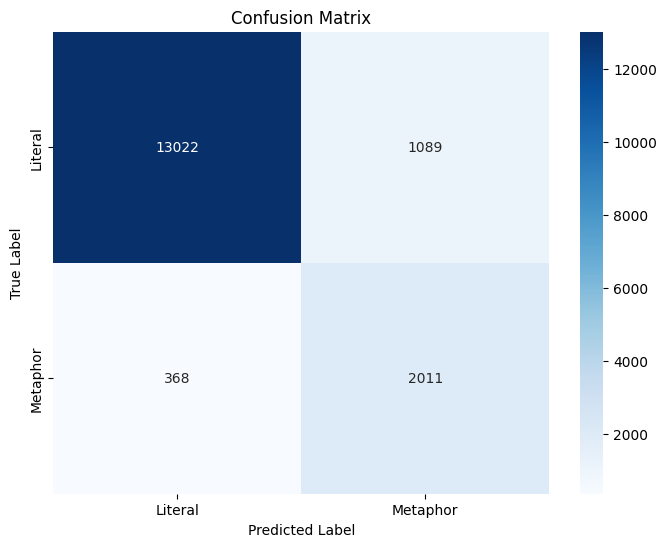

In [71]:
plot_confusion_matrix(
    results['preds'].label_ids[results['preds'].label_ids != -100].flatten(),
    results['preds'].predictions[0].argmax(-1)[results['preds'].label_ids != -100].flatten()
)


## F1 Score vs. Number of Metaphorical Samples by POS\


In [23]:
def plot_f1_vs_metaphor_samples(results, pos_categories=POS_CATEGORIES_TO_BALANCE):
    """Enhanced: dot size = total samples, label shows count"""

    preds = results['preds']
    y_true_clean = preds.label_ids[preds.label_ids != -100].flatten()
    y_pred_clean = preds.predictions[0].argmax(-1)[preds.label_ids != -100].flatten()

    # Align POS (your exact logic)
    test_ds = results['test_ds']
    mask = preds.label_ids != -100
    aligned_pos = []
    for i, mask_row in enumerate(mask):
        pos_tags = test_ds.simple_pos_list[i]
        aligned_pos.extend([pos_tags[j] for j, m in enumerate(mask_row) if m])

    # Calculate metrics per POS
    f1_scores = {}
    metaphor_counts = {}
    total_counts = {}

    for pos in pos_categories:
        pos_mask = np.array([p == pos for p in aligned_pos])
        if pos_mask.sum() == 0: continue

        y_pos_true = y_true_clean[pos_mask]
        y_pos_pred = y_pred_clean[pos_mask]

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_pos_true, y_pos_pred, average='binary', pos_label=1, zero_division=0
        )
        f1_scores[pos] = f1
        metaphor_counts[pos] = (y_pos_true == 1).sum()
        total_counts[pos] = len(y_pos_true)  # TOTAL samples for dot size

    # PLOT: size = total samples, label shows numbers
    plt.figure(figsize=(12, 8))

    # Dot sizes proportional to metaphorical samples (adjust multiplier for visibility)
    sizes = np.array([metaphor_counts[pos] * 0.8 for pos in metaphor_counts])

    scatter = plt.scatter(metaphor_counts.values(), f1_scores.values(),
                         s=sizes, alpha=0.7, c='coral', edgecolors='black', linewidth=1.5)

    # Annotate: POS + (metaphors/total)
    for pos in total_counts:
        plt.annotate(f'{pos}\n({metaphor_counts[pos]}/{total_counts[pos]})',
                    (metaphor_counts[pos], f1_scores[pos]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=10, ha='left', bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    plt.xlabel('Number of Metaphorical Samples', fontsize=12)
    plt.ylabel('Metaphor F1 Score', fontsize=12)
    plt.title('F1 Score vs. Metaphorical Samples by POS\n(Dot size \u221d metaphorical samples in POS)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print table
    print("\nPOS Analysis Table:")
    df_pos = pd.DataFrame({
        'POS': list(total_counts.keys()),
        'Total Samples': list(total_counts.values()),
        'Metaphor Samples': list(metaphor_counts.values()),
        'Metaphor %': [f"{m/t*100:.1f}%" for m,t in zip(metaphor_counts.values(), total_counts.values())],
        'F1 Metaphor': [f"{f1:.3f}" for f1 in f1_scores.values()]
    })
    print(df_pos.round(3).to_string(index=False))


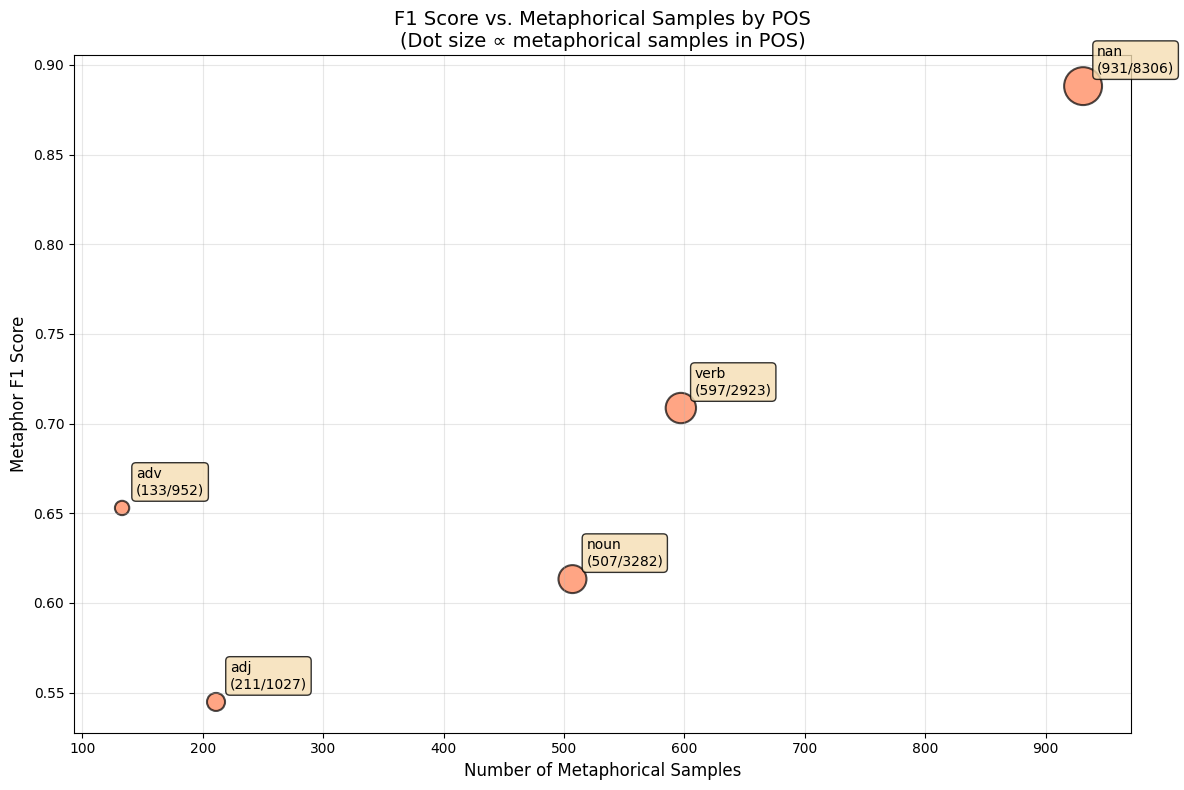


POS Analysis Table:
 POS  Total Samples  Metaphor Samples Metaphor % F1 Metaphor
noun           3282               507      15.4%       0.613
verb           2923               597      20.4%       0.709
 adj           1027               211      20.5%       0.545
 adv            952               133      14.0%       0.653
 nan           8306               931      11.2%       0.888


In [72]:
plot_f1_vs_metaphor_samples(results)

## Interpretability & Token Importance


In [25]:
!pip install captum  # Official PyTorch library for IG

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 54.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.1

In [26]:
import captum.attr as attr  # Captum attributions
import matplotlib.pyplot as plt
import seaborn as sns

def compute_integrated_gradients(model, tokenizer, sentence, target_class=1):  # 1=Metaphor
    """
    Computes IG for a single sentence, returns attribution per token.
    Applies IG with respect to input embeddings, as token IDs are discrete.
    """
    # Tokenize and move to device
    encoding = tokenizer(sentence, return_tensors='pt',
                         padding='max_length', max_length=MAX_LEN,
                         truncation=True)

    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    # Get the model's word embeddings layer
    word_embeddings = model.get_input_embeddings()

    # 1. Define a wrapper class that takes embeddings as input
    #    and passes them to the rest of the model, bypassing the embedding layer.
    class ModelForEmbeddings(torch.nn.Module):
        def __init__(self, base_model, target_class_idx):
            super().__init__()
            self.base_model = base_model
            self.target_class_idx = target_class_idx

        def forward(self, input_embeddings, attention_mask):
            # XLMRobertaForTokenClassification has 'roberta' (base model) and then a classifier head.
            # We pass the pre-computed 'input_embeddings' to the base model.
            base_model_output = self.base_model.roberta(
                inputs_embeds=input_embeddings,
                attention_mask=attention_mask,
                return_dict=True
            )
            sequence_output = base_model_output.last_hidden_state
            sequence_output = self.base_model.dropout(sequence_output)
            logits = self.base_model.classifier(sequence_output)
            # Sum logits for the target class to get a scalar output for attribution
            return logits[:, :, self.target_class_idx].sum(dim=1)

    # Initialize the wrapper model
    wrapper_model = ModelForEmbeddings(model, target_class).to(model.device)

    # Initialize IntegratedGradients with the wrapper model
    ig = attr.IntegratedGradients(wrapper_model)

    # 2. Compute actual input embeddings and a zero baseline for embeddings
    input_embeddings = word_embeddings(input_ids)
    baseline_embeddings = torch.zeros_like(input_embeddings)

    # 3. Call attribute with embeddings as inputs, and attention_mask as additional_forward_args
    #    This returns a tuple of attributions (one for inputs, one for each additional_forward_arg)
    all_attributions = ig.attribute(
        inputs=input_embeddings,
        baselines=baseline_embeddings,
        additional_forward_args=(attention_mask,),
        n_steps=50,
        internal_batch_size=1
    )

    # 4. Extract attributions for input embeddings (the first element of the tuple)
    #    and then sum across the embedding dimension to get token-level attributions
    token_attributions = all_attributions[0].sum(dim=-1).squeeze(0).detach().cpu().numpy()
    # Normalize attributions for better interpretability (optional)
    token_attributions = token_attributions / (np.sum(np.abs(token_attributions)) + 1e-8)

    return token_attributions, input_ids.squeeze(0).cpu().numpy()

In [55]:
def plot_ig_sentence(model, tokenizer, sentence, target_class=1, original_words=None):
    """
    Plots sentence with IG heat map, aggregating subword attributions to full words.
    """
    attributions, input_ids_tensor = compute_integrated_gradients(model, tokenizer, sentence, target_class)

    # Tokenize the sentence to get word_ids mapping
    tokenized_output = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=MAX_LEN)
    word_ids = tokenized_output.word_ids(batch_index=0)

    # Fallback if original_words not provided (though it should be for accuracy)
    if original_words is None:
        original_words = sentence.split()

    final_attributions = []
    final_display_words = []

    current_word_attribution_sum = 0.0
    last_word_idx = None # To track when a new original word starts
    current_word_form = None


    tokens = []
    agg_attribs = []
    i = 0
    while i < len(attributions):
        wid = word_ids[i] if i < len(word_ids) else None

        if wid is None:  # Special token
            tokens.append(tokenizer.decode([input_ids_tensor[i]]))
            agg_attribs.append(attributions[i])
            i += 1
        else:  # Word tokens (aggregate subwords)
            word_attrib_sum = 0.0
            word_parts = []
            start_i = i
            while i < len(word_ids) and word_ids[i] == wid:
                word_attrib_sum += attributions[i]
                word_parts.append(tokenizer.decode([input_ids_tensor[i]]))
                i += 1
            tokens.append(' '.join(word_parts))
            agg_attribs.append(word_attrib_sum)

    final_attributions = np.array(agg_attribs)
    final_display_words = tokens
    if final_attributions.size == 0: # Changed from 'if not final_attributions:'
        print("No meaningful items to display for attribution.")
        return

    # Plot
    plt.figure(figsize=(max(12, len(final_display_words) * 1.2), 2)) # Dynamic figsize
    sns.heatmap([final_attributions], annot=[final_display_words], fmt='', cmap='RdBu_r',
                xticklabels=False, yticklabels=False, cbar_kws={'label': 'IG Attribution'})

    plt.title(f'IG: Contributions to "{'Metaphor' if target_class==1 else 'Literal'}" Prediction (Aggregated Words)')
    plt.tight_layout()
    plt.show()

    # Print top contributors (using aggregated data)
    abs_attribs = np.abs(final_attributions)
    top_indices = np.argsort(abs_attribs)[-min(5, len(abs_attribs)):][::-1]
    print("Top contributing items:")
    for i in top_indices:
        print(f"  {final_display_words[i]:10} | attribution: {final_attributions[i]:.3f}")


=== HAND-CRAFTED TEST CASES ===

Expected: devoured
Sentence: 'He devoured the book in one sitting.'


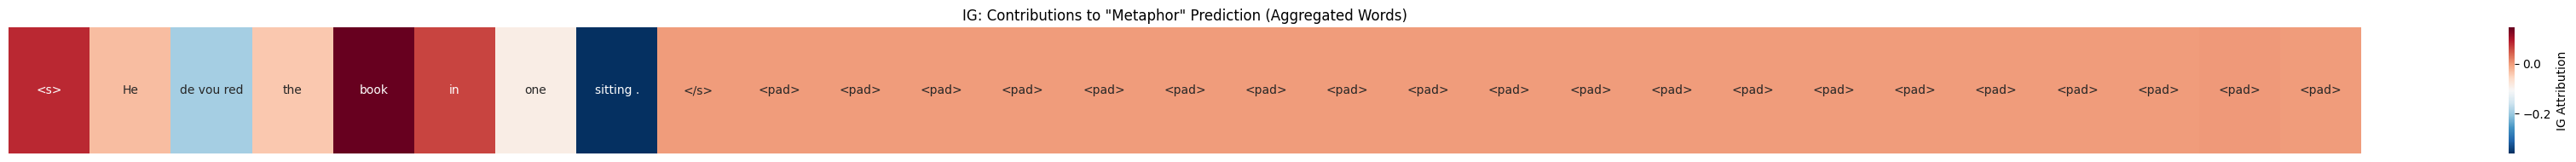

Top contributing items:
  sitting .  | attribution: -0.358
  de vou red | attribution: -0.192
  book       | attribution: 0.144
  one        | attribution: -0.088
  <s>        | attribution: 0.082


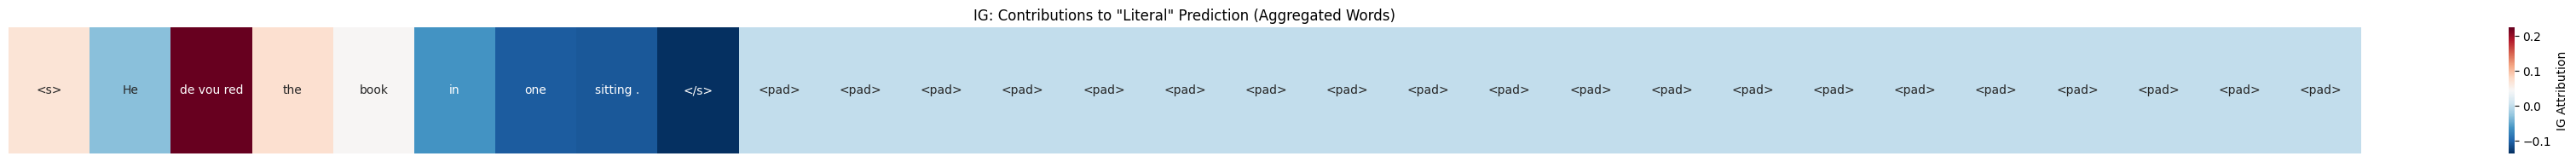

Top contributing items:
  de vou red | attribution: 0.224
  </s>       | attribution: -0.136
  sitting .  | attribution: -0.109
  one        | attribution: -0.106
  the        | attribution: 0.072

Expected: gold
Sentence: 'He has a heart of gold.'


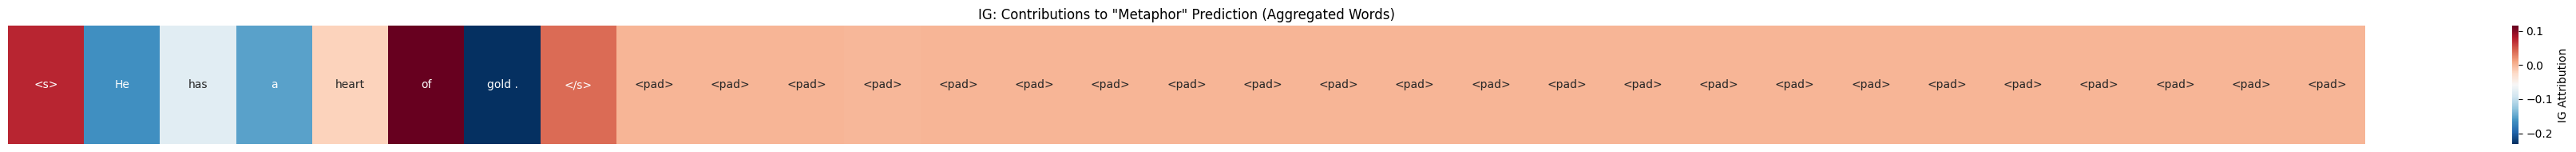

Top contributing items:
  gold .     | attribution: -0.231
  He         | attribution: -0.165
  a          | attribution: -0.152
  of         | attribution: 0.115
  has        | attribution: -0.078


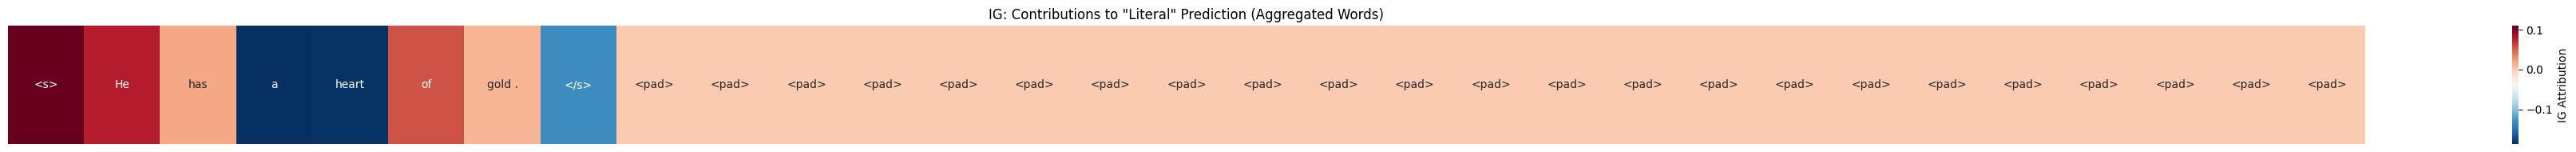

Top contributing items:
  a          | attribution: -0.187
  heart      | attribution: -0.186
  </s>       | attribution: -0.132
  <s>        | attribution: 0.110
  He         | attribution: 0.077

Expected: broke up
Sentence: 'The meeting broke up after two hours.'


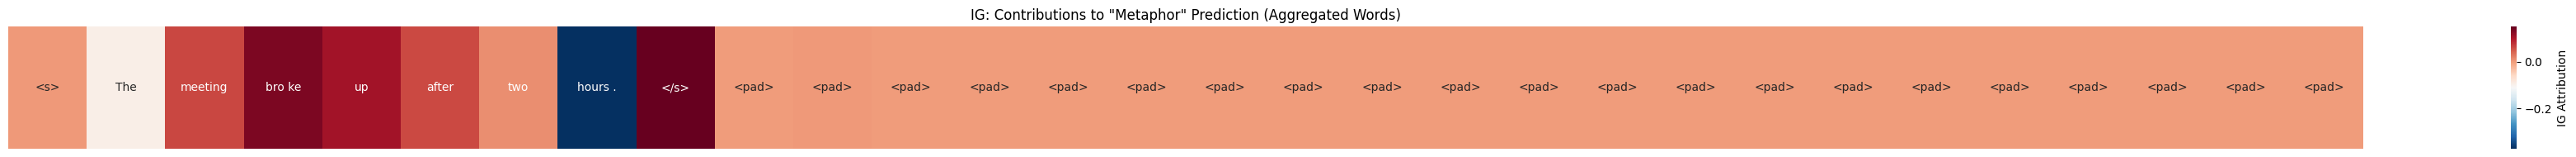

Top contributing items:
  hours .    | attribution: -0.372
  </s>       | attribution: 0.150
  bro ke     | attribution: 0.134
  up         | attribution: 0.108
  The        | attribution: -0.093


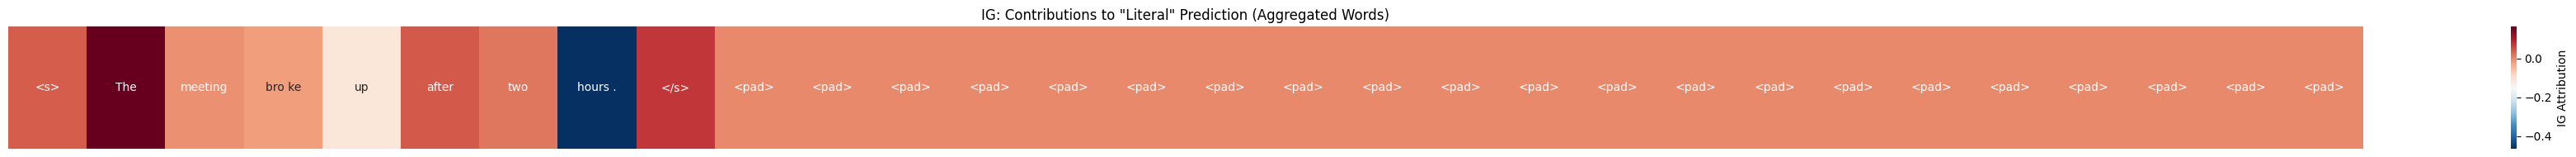

Top contributing items:
  hours .    | attribution: -0.464
  The        | attribution: 0.163
  up         | attribution: -0.113
  </s>       | attribution: 0.074
  after      | attribution: 0.041

Expected: spread
Sentence: 'The problem spread quickly through the team.'


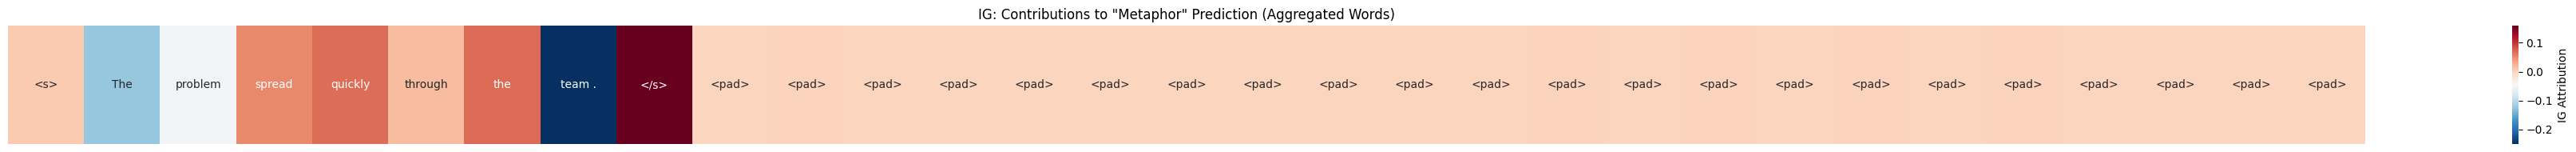

Top contributing items:
  team .     | attribution: -0.251
  </s>       | attribution: 0.159
  The        | attribution: -0.125
  the        | attribution: 0.069
  quickly    | attribution: 0.068


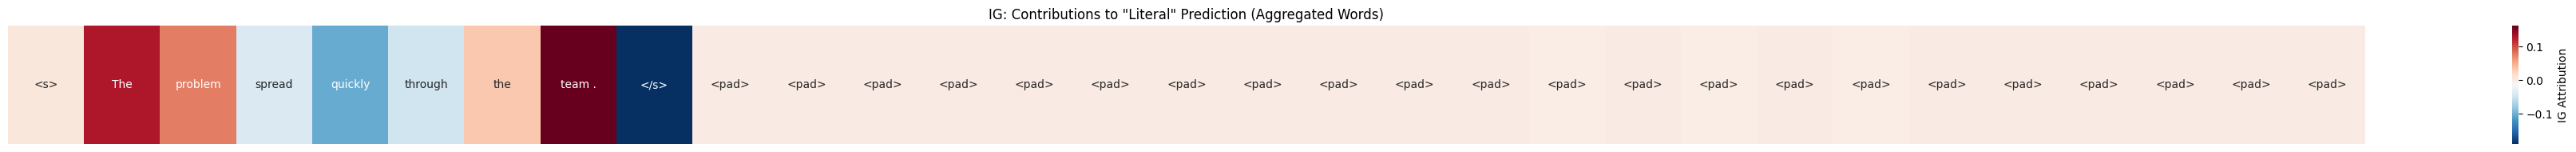

Top contributing items:
  </s>       | attribution: -0.189
  team .     | attribution: 0.161
  The        | attribution: 0.127
  quickly    | attribution: -0.102
  problem    | attribution: 0.076



In [73]:
# === HAND-CRAFTED EXAMPLES ===
handcrafted_examples = [
    {
        "text": "He devoured the book in one sitting.",
        "expected_metaphor": "devoured"
    },
    {
        "text": "He has a heart of gold.",
        "expected_metaphor": "gold"
    },
    {
        "text": "The meeting broke up after two hours.",
        "expected_metaphor": "broke up"
    },
    {
        "text": "The problem spread quickly through the team.",
        "expected_metaphor": "spread"
    }
]

print("=== HAND-CRAFTED TEST CASES ===\n")
for ex in handcrafted_examples:
    print(f"Expected: {ex['expected_metaphor']}")
    print(f"Sentence: '{ex['text']}'")

    plot_ig_sentence(trainer.model, tokenizer, ex['text'], target_class=1)
    plot_ig_sentence(trainer.model, tokenizer, ex['text'], target_class=0)
    print()


=== HAND-CRAFTED TEST CASES ===

Expected: разбила
Sentence: 'Партия разбила лагерь на окраине города.'


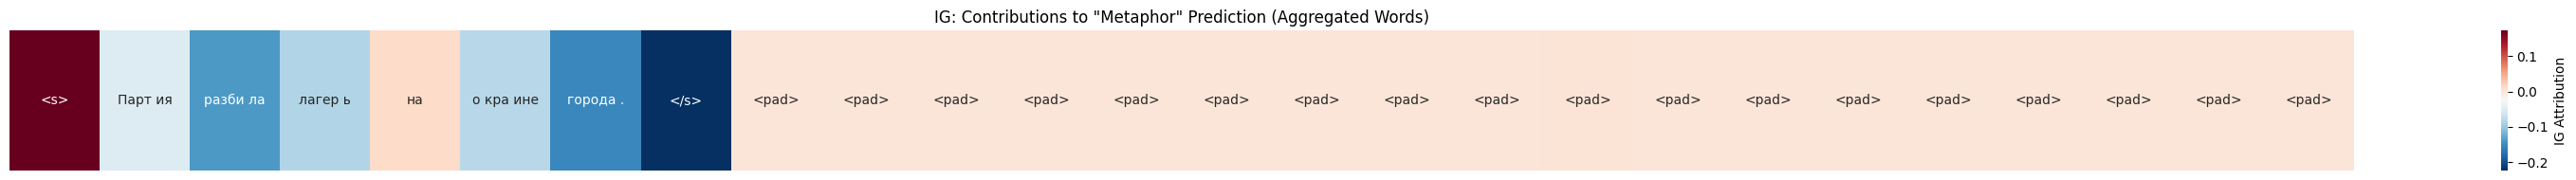

Top contributing items:
  </s>       | attribution: -0.223
  <s>        | attribution: 0.172
  города .   | attribution: -0.154
  разби ла   | attribution: -0.139
  лагер ь    | attribution: -0.084


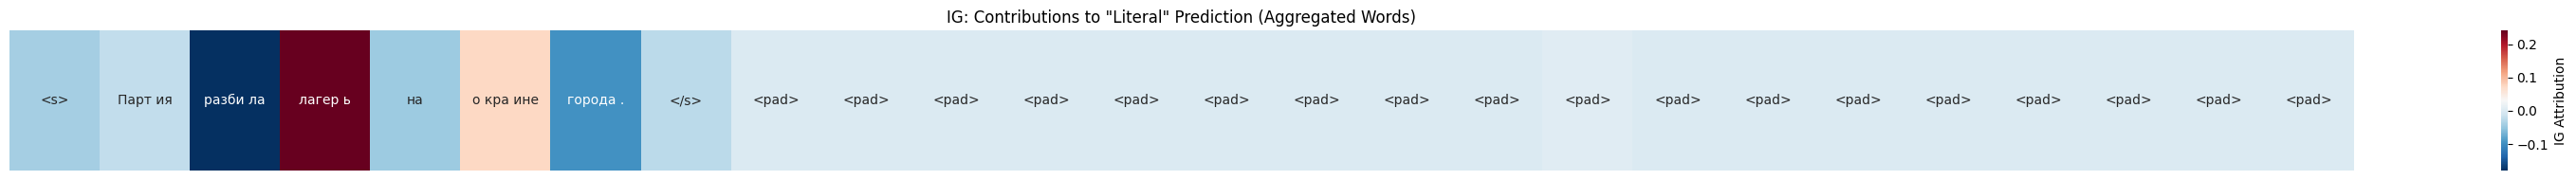

Top contributing items:
  лагер ь    | attribution: 0.241
  разби ла   | attribution: -0.179
  города .   | attribution: -0.097
  о кра ине  | attribution: 0.074
  на         | attribution: -0.047

Expected: распространился
Sentence: 'Кризис распространился по всей стране.'


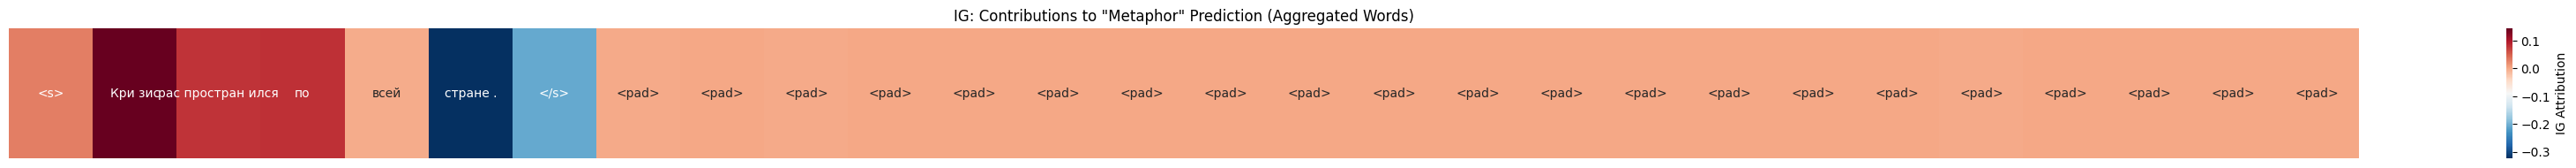

Top contributing items:
  стране .   | attribution: -0.324
  </s>       | attribution: -0.210
  Кри зис    | attribution: 0.144
  по         | attribution: 0.082
  рас простран ился | attribution: 0.079


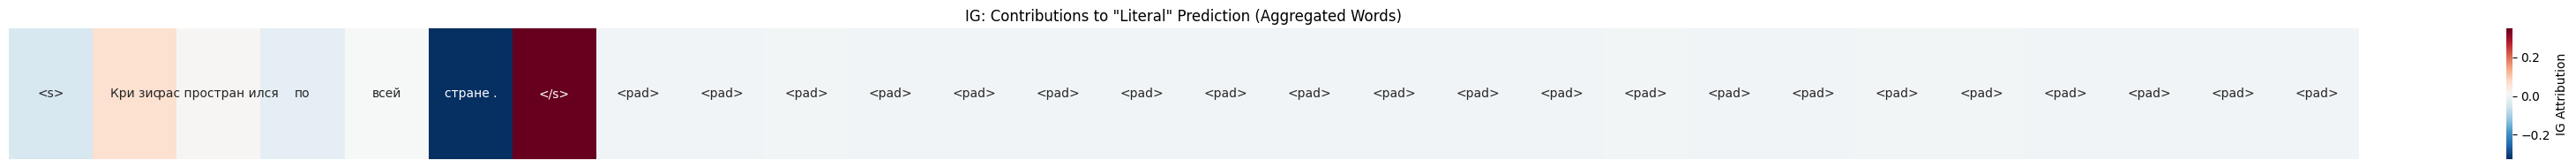

Top contributing items:
  </s>       | attribution: 0.348
  стране .   | attribution: -0.326
  Кри зис    | attribution: 0.065
  <s>        | attribution: -0.044
  по         | attribution: -0.023

Expected: захватила
Sentence: 'Компания захватила лидерство на рынке.'


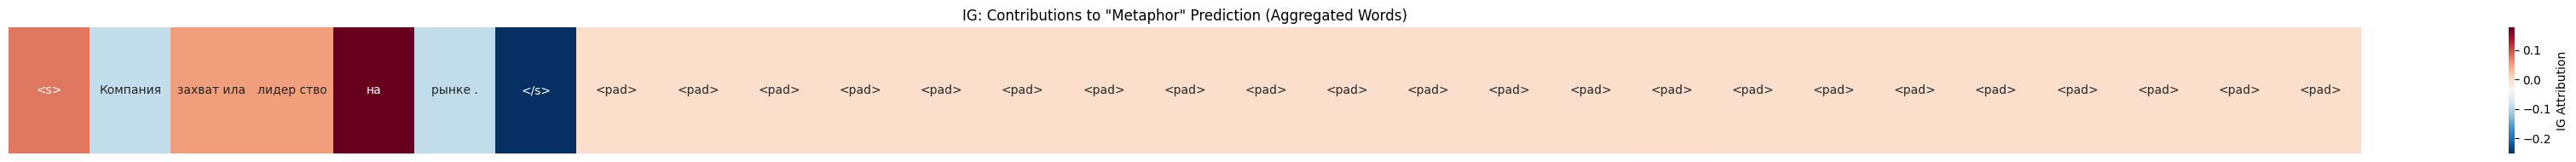

Top contributing items:
  </s>       | attribution: -0.252
  на         | attribution: 0.176
  рынке .    | attribution: -0.092
  Компания   | attribution: -0.090
  <s>        | attribution: 0.077


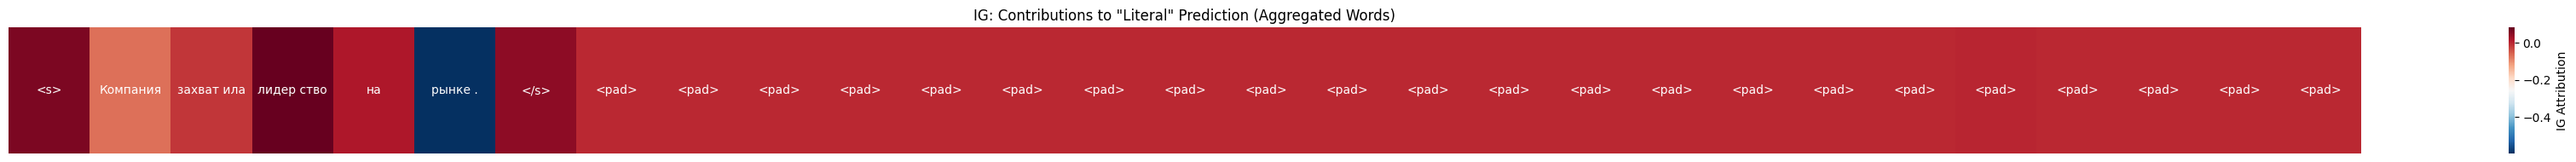

Top contributing items:
  рынке .    | attribution: -0.597
  лидер ство | attribution: 0.083
  Компания   | attribution: -0.071
  <s>        | attribution: 0.062
  </s>       | attribution: 0.045

Expected: пожирает
Sentence: 'Инфляция пожирает сбережения населения.'


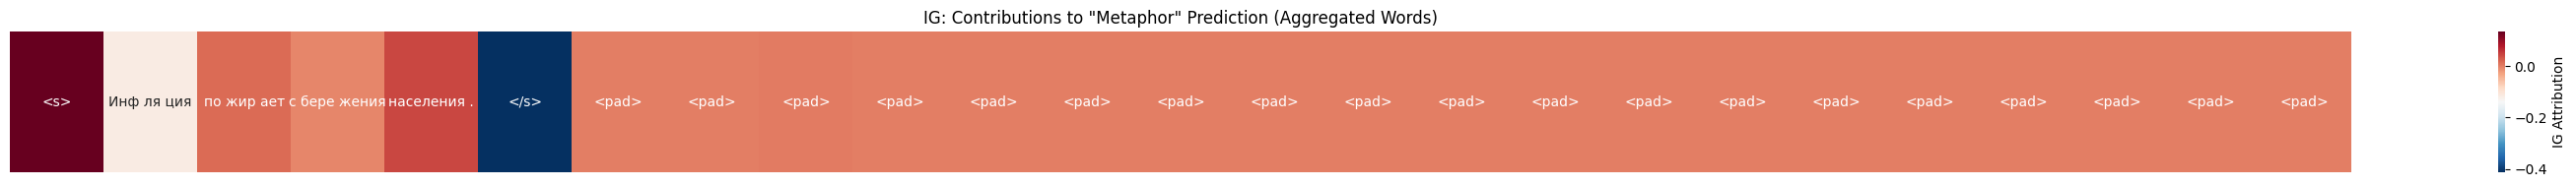

Top contributing items:
  </s>       | attribution: -0.413
  <s>        | attribution: 0.133
  Инф ля ция | attribution: -0.116
  населения . | attribution: 0.043
  по жир ает | attribution: 0.014


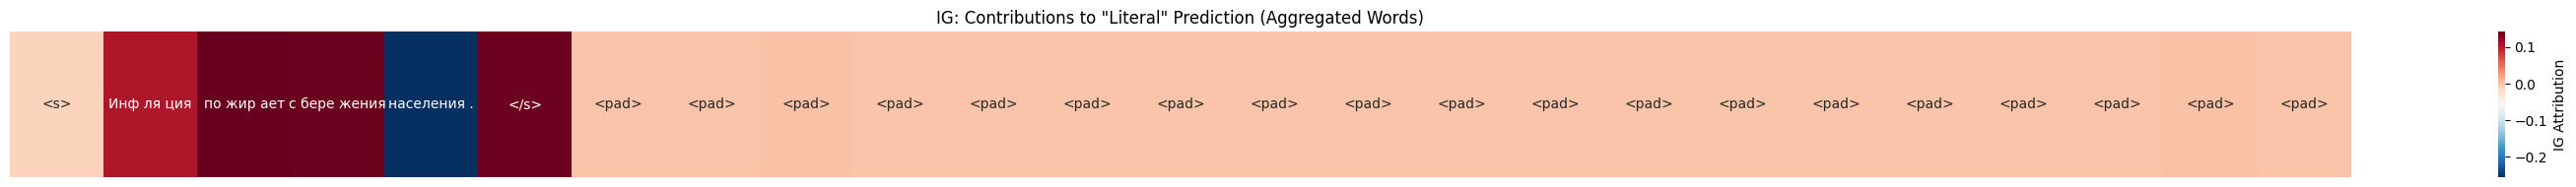

Top contributing items:
  населения . | attribution: -0.256
  по жир ает | attribution: 0.142
  с бере жения | attribution: 0.139
  </s>       | attribution: 0.138
  Инф ля ция | attribution: 0.104



In [68]:
# === HAND-CRAFTED EXAMPLES ===
handcrafted_examples = [
    {
        "text": "Партия разбила лагерь на окраине города.",
        "expected_metaphor": "разбила"
    },
    {
        "text": "Кризис распространился по всей стране.",
        "expected_metaphor": "распространился"
    },
    {
        "text": "Компания захватила лидерство на рынке.",
        "expected_metaphor": "захватила"
    },
    {
        "text": "Инфляция пожирает сбережения населения.",
        "expected_metaphor": "пожирает"
    }
]

print("=== HAND-CRAFTED TEST CASES ===\n")
for ex in handcrafted_examples:
    print(f"Expected: {ex['expected_metaphor']}")
    print(f"Sentence: '{ex['text']}'")

    plot_ig_sentence(trainer.model, tokenizer, ex['text'], target_class=1)
    plot_ig_sentence(trainer.model, tokenizer, ex['text'], target_class=0)
    print()
